In [38]:
import numpy as np
import pandas as pd
from joblib import load
import joblib
import matplotlib.pyplot as plt

In [39]:
model = load("../data/models/final_model_lgbm.pkl")
preprocessor = load("../data/models/preprocessor.pkl")

X_train, X_test, y_train, y_test = load(
    "../data/models/train_test_split.pkl"
)

In [40]:
X_test_processed = preprocessor.transform(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

c:\Users\GENERAL STORES-SARL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [41]:
LOAN_AMOUNT = 5_000_000       # XAF
INTEREST_RATE = 0.12         # 12%

In [42]:
def compute_profit(y_true, y_proba, threshold,
                   loan_amount=LOAN_AMOUNT,
                   interest_rate=INTEREST_RATE):
    decisions = (y_proba < threshold).astype(int)  # 1 = accepté

    profit = 0
    for yt, dec in zip(y_true, decisions):
        if dec == 1 and yt == 0:      # Vrai Négatif
            profit += loan_amount * interest_rate
        elif dec == 1 and yt == 1:    # Faux Négatif (défaut)
            profit -= loan_amount
        # rejet = 0
    return profit

In [43]:
thresholds = np.linspace(0.01, 0.99, 99)
profits = []

for t in thresholds:
    p = compute_profit(y_test.values, y_proba, t)
    profits.append(p)

profit_df = pd.DataFrame({
    "threshold": thresholds,
    "profit": profits
})

In [44]:
optimal_row = profit_df.loc[profit_df["profit"].idxmax()]
optimal_threshold = optimal_row["threshold"]
optimal_profit = optimal_row["profit"]

optimal_threshold, optimal_profit

(np.float64(0.29000000000000004), np.float64(1840200000.0))

In [45]:
profit_05 = compute_profit(y_test.values, y_proba, 0.5)
profit_opt = optimal_profit

print("Profit seuil 0.5 :", profit_05)
print("Profit seuil optimal :", profit_opt)

Profit seuil 0.5 : 1492000000.0
Profit seuil optimal : 1840200000.0


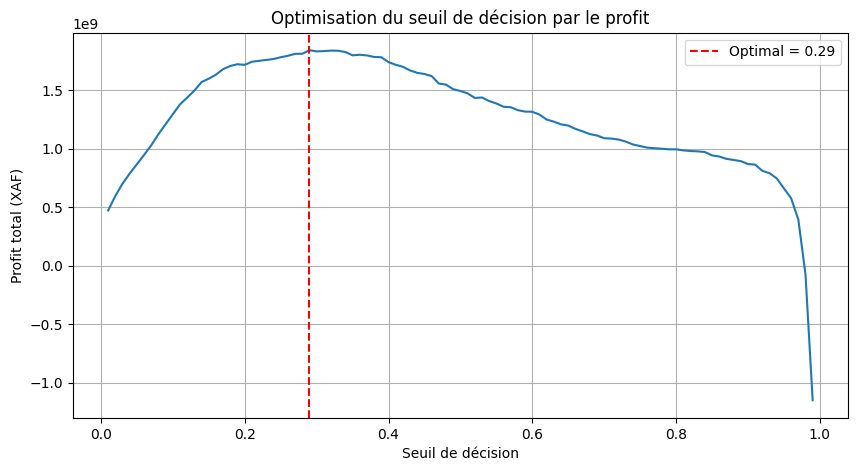

In [46]:
plt.figure(figsize=(10,5))
plt.plot(profit_df["threshold"], profit_df["profit"])
plt.axvline(optimal_threshold, color="red", linestyle="--",
            label=f"Optimal = {optimal_threshold:.2f}")
plt.xlabel("Seuil de décision")
plt.ylabel("Profit total (XAF)")
plt.title("Optimisation du seuil de décision par le profit")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
risk_config = {
    "optimal_threshold": float(optimal_threshold),
    "profit_threshold_05": float(profit_05),
    "profit_optimal": float(profit_opt),
    "loan_amount": LOAN_AMOUNT,
    "interest_rate": INTEREST_RATE
}

joblib.dump(risk_config, "../data/models/risk_config.pkl")

['../data/models/risk_config.pkl']